In [162]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from datasets import load_dataset 
import numpy as np
from PIL import Image, ImageFilter
import os, random
import pandas as pd
import transformers as tr
import matplotlib.pyplot as plt
import json
import shutil
import copy

In [2]:
# DO NOT RUN CELL!

"""lines = []
with open("hateful_memes/train.jsonl") as f:
    lines = f.read().splitlines()

lines_dict = [json.loads(line) for line in lines]

df = pd.DataFrame(lines_dict)
print(df.loc[[0]])"""

      id            img  label  \
0  42953  img/42953.png      0   

                                               text  
0  its their character not their color that matters  


In [12]:
# DO NOT RUN CELL!
'''
imgs_referenced = df["img"]
imgs_referenced.astype(str)

def select_ref_imgs(orig_loc):
    orig_loc = str(orig_loc)
    file_name = orig_loc[4:]
   
    try:
        shutil.move(f".\hateful_memes\{orig_loc}", f".\hateful_memes\imgs_present/{file_name}")
        print(f"file {file_name} moved")
    except FileNotFoundError:
        print(f"file {file_name} not found")
        pass
    except Exception as e:
        print(f"error:{e}")

def change_slash(string):
    string = string.replace("/",  "\ " )
    string = string.replace(" ", "")
    return string
    '''

# imgs_referenced = imgs_referenced.apply(change_slash)
# imgs_referenced.apply(select_ref_imgs)

print("files moved")

files moved


In [13]:
# DO NOT RUN CELL!

# for file_name in os.listdir("./hateful_memes/img"):
    # file_path = os.path.join("./hateful_memes/img", file_name)
    # os.remove(file_path)
    # print(f"{file_path} deleted.")
    # pass
print ("files deleted")

files deleted


In [ ]:
# DO NOT RUN CELL!

# shutil.rmtree("hateful_memes/img_old")

In [7]:
# DO NOT RUN CELL!

# os.rename("hateful_memes/imgs_present", "hateful_memes/img")

In [14]:
# DO NOT RUN CELL!

"""def check_imgs_exist(file_path):
    file_path = str(file_path)
    file_name = file_path[4:]
    if os.path.isfile(f"hateful_memes/{file_path}"):
        # print(f"{file_name} present")
        return True
    else:
        return False
    
reference_df = df
reference_df["img_exists"] = reference_df["img"].apply(check_imgs_exist)
reference_df = reference_df[reference_df["img_exists"]]
reference_df = reference_df.drop(columns=["img_exists"])
reference_df = reference_df.reset_index()
"""

files present


In [4]:
# DO NOT RUN CELL!

# print(reference_df.head(), len(reference_df))

   index     id            img  label  \
0      0  42953  img/42953.png      0   
1      2  13894  img/13894.png      0   
2      4  82403  img/82403.png      0   
3      5  16952  img/16952.png      0   
4      6  76932  img/76932.png      0   

                                                text  
0   its their character not their color that matters  
1                           putting bows on your pet  
2  everybody loves chocolate chip cookies, even h...  
3           go sports! do the thing! win the points!  
4     fine you're right. now can we fucking drop it?   6744


In [ ]:
# DO NOT RUN CELL!

# print(reference_df.query("id == '14507'"))

     index     id            img  label  \
882   1112  14507  img/14507.png      1   

                                                  text  
882  when your history teacher starts talking about...  


In [15]:
# DO NOT RUN CELL!

# reference_df = reference_df.astype({"index":int, "id":int, "img":str, "label":float, "text":str})
# data = reference_df

# data.to_csv("data.csv")

In [2]:
data = pd.read_csv("data.csv")
print (data.head())

   Unnamed: 0  index     id            img  label  \
0           0      0  42953  img/42953.png    0.0   
1           1      2  13894  img/13894.png    0.0   
2           2      4  82403  img/82403.png    0.0   
3           3      5  16952  img/16952.png    0.0   
4           4      6  76932  img/76932.png    0.0   

                                                text  
0   its their character not their color that matters  
1                           putting bows on your pet  
2  everybody loves chocolate chip cookies, even h...  
3           go sports! do the thing! win the points!  
4     fine you're right. now can we fucking drop it?  


In [167]:
class DatasetTxt (Dataset):
    def __init__(self, df, tokenizer):
        super().__init__()
        self.df = df
        self.tokenizer = tokenizer

        self.text= df["text"].values
        self.label = df["label"].values

    def __len__(self):
        return len(self.df["label"])
    
    def __getitem__(self, index):
        text = self.text[index]
        label = self.label[index]

        encoding = self.tokenizer.encode_plus(text, add_special_tokens=True, return_token_type_ids=False,
            padding='longest', return_attention_mask=True, return_tensors='pt', truncation=True)

        return {"input_ids": encoding["input_ids"].flatten(), "attention_mask": encoding["attention_mask"].flatten(),
                "labels": t.tensor(label, dtype=t.long)}
        
class DatasetImg (Dataset):
    def __init__(self, df, img_dir):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

        self.img= df["img"].values
        self.label = df["label"].astype(int).values

    def __len__(self):
        return len(self.df["label"])
    
    def __getitem__(self, index):
        img_pth = os.path.join(self.img_dir, self.img[index])
        img = Image.open(img_pth).convert("RGB")
        img_tensor = self.transform(img).unsqueeze(0)
        img_tensor = img_tensor.squeeze(1)
        label = self.label[index]

        return img_tensor, label



In [168]:
# splitting data: 30% for fine-tuning of sub-models (of which, 20% for validation)

hb_and_rs, rest = train_test_split(data, test_size= 0.7)
fine_tuning_subm, validation_subm = train_test_split(hb_and_rs, test_size=0.2)

In [169]:
tokenizer = tr.BertTokenizer.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english", clean_up_tokenization_spaces=True)

In [170]:
text_ds = DatasetTxt(fine_tuning_subm, tokenizer=tokenizer)
text_ds_val = DatasetTxt(validation_subm, tokenizer=tokenizer)

In [171]:
imag_ds = DatasetImg(fine_tuning_subm, img_dir="hateful_memes/")
imag_ds_val = DatasetImg(validation_subm, img_dir="hateful_memes/")

In [172]:
d_collator = tr.DataCollatorWithPadding(tokenizer=tokenizer)

In [173]:
train_loader_txt = DataLoader(text_ds, batch_size=16, shuffle=True, collate_fn=d_collator)
train_loader_img = DataLoader(imag_ds, batch_size=16, shuffle=True)
loader_txt_val = DataLoader(text_ds, batch_size=16, shuffle=True, collate_fn=d_collator)
loader_img_val = DataLoader(imag_ds, batch_size=16, shuffle=True)

In [174]:
class MonoLateFusModel(nn.Module):
    def __init__(self, text_model, img_model, classes):
        super().__init__()
        self.text_model = text_model

        in_features_img = img_model.fc.in_features
        img_model.fc = nn.Linear(in_features_img, 2)
        self.img_model = img_model


        # architecture
        #ToxicBERT/HateBERT input
        self.textfc = nn.Sequential(
            nn.Linear(classes, 24),
            nn.ReLU(),
            nn.Dropout(0.3),)
        #ResNet input
        self.imgfc = nn.Sequential(
            nn.Linear(classes, 24),
            nn.ReLU(),
            nn.Dropout(0.3),)

        # Fusion and classification
        self.mlp = nn.Sequential(
            nn.Linear(48, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 2),)

    def forward(self, tokenized_text, image):
        cloned_txt_model = copy.deepcopy(self.text_model)
        cloned_img_model = copy.deepcopy(self.img_model)

        if "labels" in tokenized_text.keys(): #check if the input has labels (model in training)
        
            toktext = tokenized_text["input_ids"]
            mask = tokenized_text["attention_mask"]
            labels = tokenized_text["labels"]

            # txt_proc = self.textfc(self.text_model(tokenized_text))
            # img_proc = self.imgfc(self.img_model(image))

            logits_for_txt = cloned_txt_model(input_ids=toktext, attention_mask=mask, labels=labels).logits
        
        else: #otherwise, model in evaluation, labels not required
            toktext = tokenized_text["input_ids"]
            mask = tokenized_text["attention_mask"]

            logits_for_txt = cloned_txt_model(input_ids=toktext, attention_mask=mask).logits
        
        img_t = cloned_img_model(image)

        #print(f"HateBERT output: {logits_for_txt.shape}")
        #print(f"ResNet-18 output: {img_t.shape}")

        txt_proc = self.textfc(logits_for_txt)
        img_proc = self.imgfc(img_t)

        #print(f"text data after mlp: {txt_proc.shape}")
        #print(f"image data after mlp: {img_proc.shape}")

        txt_fft = t.fft.fft(txt_proc).real
        img_fft = t.fft.fft(img_proc).real
        #print(f"txt_fft shape: {txt_fft.shape}",f"img_fft shape: {img_fft.shape}")
        fusion = t.cat([txt_fft, img_fft], dim=1)
        #print(f"fusion shape: {fusion.shape}")
        logits = self.mlp(fusion)
        #print(f"logits shape: {logits.shape}")

        return logits

    def evaluate_subpart(self, dataloader_val, input_type):
        model = self.text_model if input_type == "txt" else self.img_model
        model.eval()

        val_loss = 0
        val_correct_preds = 0
        val_tot_elements = 0

        criterion = nn.CrossEntropyLoss()

        if input_type == "txt":
            with t.no_grad(): #validation
                for val_batch in dataloader_val:
                    val_toktext = val_batch["input_ids"]
                    val_mask = val_batch["attention_mask"]
                    val_label = val_batch["labels"]
                    
                    val_outputs = model(input_ids=val_toktext, attention_mask=val_mask, labels=val_label)

                    current_loss_val = val_outputs.loss

                    val_loss += current_loss_val.item()
                    val_logits = val_outputs.logits

                    val_pred = t.argmax(val_logits, -1)

                    val_correct_preds += t.sum(val_pred == val_label)
                    val_tot_elements += len(val_label)

        elif input_type == "img":
            with t.no_grad():
                for val_images, val_labels in dataloader_val:
                        
                    val_images = val_images.squeeze(1)

                    val_outputs = model(val_images)

                    current_loss_val = criterion(val_outputs.float(), val_labels)
                    val_loss += current_loss_val.item()
                                        
                    _, val_pred = t.max(val_outputs.data, 1)

                    val_correct_preds += t.sum(val_pred == val_labels)
                    val_tot_elements += len(val_labels)

        print(f"val loss: {val_loss/(len(dataloader_val)):.4f}, val accuracy: {100*val_correct_preds.float()/val_tot_elements:.2f}")


    def fine_tune_subpart(self, dataloader_train, dataloader_val,  input_type):
        model = self.text_model if input_type == "txt" else self.img_model

        train_loss = 0
        train_correct_preds = 0
        train_tot_elements = 0

        if input_type == "txt":
            optimizer_txt = optim.AdamW(model.parameters(), lr= 5e-5)
            scheduler = optim.lr_scheduler.StepLR(optimizer_txt, step_size=1, gamma=0.9)
        elif input_type == "img":
            criterion = nn.CrossEntropyLoss()
            optimizer_img = optim.Adam(model.fc.parameters(), lr=0.001)

        for e in range(8):
            model.train()
            if input_type == "txt":
                for name, param in model.named_parameters():
                    if "classifier" not in name:
                        param.requires_grad = False

                for batch in dataloader_train:
                    toktext = batch["input_ids"]
                    mask = batch["attention_mask"]
                    labels = batch["labels"]

                    outputs = model(input_ids=toktext, attention_mask=mask, labels=labels)
                    
                    loss = outputs.loss
                    logits = outputs.logits

                    optimizer_txt.zero_grad()
                    loss.backward()

                    nn.utils.clip_grad_norm_([p for p in model.parameters() if p.requires_grad], max_norm=1.0) 

                    optimizer_txt.step()
                    scheduler.step()
                    train_loss += loss.item()

                    pred = t.argmax(logits, -1)
                    train_correct_preds += t.sum(pred == labels)
                    train_tot_elements += len(labels)
                    

            elif input_type == "img":
                for name, param in model.named_parameters():
                                if "fc" not in name:
                                    param.requires_grad = False

                for images, labels in dataloader_train:

                    images = images.squeeze(1)

                    optimizer_img.zero_grad()
                    outputs = model(images)
                    
                    loss = criterion(outputs.float(), labels)
                    loss.backward()

                    nn.utils.clip_grad_norm_([p for p in model.parameters() if p.requires_grad], max_norm=1.0) 

                    optimizer_img.step()
                    train_loss += loss.item()
                                        
                    _, pred = t.max(outputs.data, 1)
                    train_correct_preds += t.sum(pred == labels)
                    train_tot_elements += len(labels)
            
            else:
                print ("input_type must be either 'txt' or 'img'")
            
            print(f"epoch {e+1}/8", 
        f"train loss: {train_loss/(len(dataloader_train)*(e+1)):.4f}, train accuracy: {100*train_correct_preds/train_tot_elements:.2f}")
            self.evaluate_subpart(dataloader_val, input_type)   


In [175]:
model_txt = tr.AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english", num_labels = 2)
model_img = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

In [176]:
hmc_model = MonoLateFusModel(text_model=model_txt, img_model=model_img, classes=2)

In [ ]:
hmc_model.fine_tune_subpart(train_loader_txt, loader_txt_val, "txt")

In [177]:
hmc_model.fine_tune_subpart(train_loader_img, loader_img_val, "img")

epoch 1/8 train loss: 0.7071, train accuracy: 59.77
val loss: 0.6455, val accuracy: 62.24
epoch 2/8 train loss: 0.6762, train accuracy: 62.14
val loss: 0.6289, val accuracy: 65.76
epoch 3/8 train loss: 0.6701, train accuracy: 62.55
val loss: 0.5922, val accuracy: 67.99
epoch 4/8 train loss: 0.6609, train accuracy: 63.15
val loss: 0.7678, val accuracy: 64.15
epoch 5/8 train loss: 0.6545, train accuracy: 63.72
val loss: 0.5683, val accuracy: 70.83
epoch 6/8 train loss: 0.6476, train accuracy: 64.26
val loss: 0.5718, val accuracy: 70.33
epoch 7/8 train loss: 0.6418, train accuracy: 64.86
val loss: 0.5810, val accuracy: 68.67
epoch 8/8 train loss: 0.6379, train accuracy: 65.18
val loss: 0.5836, val accuracy: 68.67


In [53]:
class dataset_hmc (Dataset):
    def __init__(self, df, tokenizer, img_path):
        super().__init__()
        self.df = df
        self.tokenizer = tokenizer
        self.img_dir = img_path
        self.transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

        self.text= df["text"].values
        self.label = df["label"].values
        self.img = df["img"].values

    def __len__(self):
        return len(self.df["label"])
    
    def __getitem__(self, index):
        
        text = self.text[index]
        label = self.label[index]

        encoding = self.tokenizer.encode_plus(text, add_special_tokens=True, return_token_type_ids=False,
            padding='longest', return_attention_mask=True, return_tensors='pt', truncation=True)
        
        img_pth = os.path.join(self.img_dir, self.img[index])
        img = Image.open(img_pth).convert("RGB")
        img_tensor = self.transform(img).unsqueeze(0)
        img_tensor = img_tensor.squeeze(1)
        label = self.label[index]

        return {"input_ids": encoding["input_ids"].flatten(), 
                "attention_mask": encoding["attention_mask"].flatten(),
                "img_tensor": img_tensor,
                "labels": t.tensor(label, dtype=t.long),
            }

In [178]:
# 50% of the whole dataset for training the multimodal model. 10% for validation and 10% for testing

train_hmc, test = train_test_split(rest, test_size=0.10)
# validation_hmc, test_hmc = train_test_split(val_and_test, test_size=0.5)
train_hmc_labels = train_hmc["label"].tolist()
train_hmc_data = train_hmc[["img", "text"]].values.tolist()

train_hmc_labels = np.array(train_hmc_labels)
train_hmc_data = np.array(train_hmc_data)


[0. 0. 1. ... 0. 0. 0.]
[['img/21890.png'
  'transgenderman (fallonfox) brutally beats black woman in ufc match']
 ['img/20435.png' 'kids playing in the backyard']
 ['img/89740.png' 'africa 100 years ago africa today + aids']
 ...
 ['img/24586.png' 'laundry day']
 ['img/96583.png'
  'for just ten cents a day you can help feed these children']
 ['img/80395.png' "andy, she's a nut!!!"]]


In [132]:
#train_ds_hmc = dataset_hmc(df=train_hmc, tokenizer=tokenizer, img_path="hateful_memes/")
#val_ds_hmc = dataset_hmc(df=validation_hmc, tokenizer=tokenizer, img_path="hateful_memes/")
test_ds_hmc = dataset_hmc(df=test, tokenizer=tokenizer, img_path="hateful_memes/")
#val_test_ds_hmc = dataset_hmc(df=val_and_test, tokenizer=tokenizer, img_path="hateful_memes/")

In [133]:
#train_dataloader_hmc = DataLoader(train_ds_hmc, batch_size=16, shuffle=True, collate_fn=d_collator)
# val_dataloader_hmc = DataLoader(val_ds_hmc, batch_size=16, shuffle=True, collate_fn=d_collator)
test_dataloader_hmc = DataLoader(test_ds_hmc, batch_size=16, shuffle=True, collate_fn=d_collator)
# vt_dataloader_hmc = DataLoader(val_test_ds_hmc, batch_size=16, shuffle=True, collate_fn=d_collator)

In [181]:
def train_model(dataloader, class_weights):
    hmc_model.img_model.train()
    for name, param in hmc_model.img_model.named_parameters():
        if "fc" not in name:
            param.requires_grad = False

    hmc_model.text_model.train()
    for name, param in hmc_model.text_model.named_parameters():
        if "classifier" not in name:
            param.requires_grad = False

    for name, param in hmc_model.named_parameters():
        if not param.requires_grad and param.grad is not None:
            print(f"Warning: {name} has a gradient despite being frozen.")
        #print(f"{name}: requires_grad={param.requires_grad}")

    hmc_model.train()

    train_params = [{"params": [p for n, p in hmc_model.named_parameters() if p.requires_grad and not n.endswith("bias")],"weight_decay": 0.01,},
        {"params": [p for n, p in hmc_model.named_parameters() if p.requires_grad and n.endswith("bias")],"weight_decay": 0.0,}]

    total_loss = 0
    correct_preds = 0
    total_elements = 0

    loss_function = nn.CrossEntropyLoss(weight=class_weights)
    optimizer_general = t.optim.AdamW(train_params, lr=1e-4)
    # optimizer_img = optim.Adam(hmc_lf_model.img_model.fc.parameters(), lr=0.001)
    # optimizer_txt = optim.AdamW(hmc_lf_model.text_model.parameters(), lr= 5e-5)
    # scheduler = optim.lr_scheduler.StepLR(optimizer_txt, step_size=1, gamma=0.9)

    for e in range(7):
        for batch in dataloader:
            
            text_data = {
            "input_ids": batch["input_ids"],
            "attention_mask": batch["attention_mask"],
            "labels": batch["labels"]
            }
            img = batch["img_tensor"]
            img_squeezed = img.squeeze(1)
            label = batch["labels"]

            outputs = hmc_model(text_data,img_squeezed)

            loss = loss_function(outputs, label)

            optimizer_general.zero_grad()
            loss.backward()
            optimizer_general.step()

            total_loss += loss.item()
            _, pred = t.max(outputs.data, 1)

            correct_preds += t.sum(pred == label)
            total_elements += len(label)

        print(f"epoch {e+1}/7", 
            f"loss: {total_loss/(len(dataloader)*(e+1)):.4f}, accuracy: {100*correct_preds/total_elements:.2f}")


In [179]:
weights = t.tensor([0.647, 0.353]) # using weights for loss function based on the proportion of labels

In [137]:
# train_model(train_dataloader_hmc, weights)

epoch 1/10 loss: 0.5156, accuracy: 69.08
epoch 2/10 loss: 0.4667, accuracy: 70.96
epoch 3/10 loss: 0.4483, accuracy: 71.47
epoch 4/10 loss: 0.4385, accuracy: 71.78
epoch 5/10 loss: 0.4328, accuracy: 71.84
epoch 6/10 loss: 0.4292, accuracy: 72.01
epoch 7/10 loss: 0.4258, accuracy: 72.08
epoch 8/10 loss: 0.4216, accuracy: 72.12
epoch 9/10 loss: 0.4189, accuracy: 72.18
epoch 10/10 loss: 0.4169, accuracy: 72.16


In [160]:
def eval_model(dataloader):
    hmc_model.text_model.eval()
    hmc_model.img_model.eval()
    hmc_model.eval()

    loss_function = nn.CrossEntropyLoss()

    n_batch = 0
    val_loss = 0
    val_correct = 0
    val_total_el = 0
    pred_prob_total =[]
    label_total = []
    with t.no_grad():

        for batch in dataloader:
            text_data_val = {
            "input_ids": batch["input_ids"],
            "attention_mask": batch["attention_mask"]
            }
            img_val = batch["img_tensor"]
            img_val = img_val.squeeze(1)
            label_val = batch["labels"]
            
            # print(text_data)
            val_outputs = hmc_model(text_data_val,img_val)
            #print (outputs)
            loss_val = loss_function(val_outputs, label_val)

            val_loss += loss_val.item()
            _, val_pred = t.max(val_outputs.data, 1)

            # print(f"predictions shape: {val_pred.shape}", f"labels shape: {label_val.shape}")

            val_correct += t.sum(val_pred == label_val)
            val_total_el += len(label_val)

            pred_probs = t.softmax(val_outputs, dim=1)[:, 1]
            pred_prob_total.extend(pred_probs.numpy())
            label_total.extend(label_val.numpy())
            roc_auc = roc_auc_score(label_val, pred_probs)

            n_batch +=1
            if len(dataloader) % n_batch == 0:
                print(f"correct values: {t.sum(val_pred == label_val)}/16, accuracy for batch: {100*t.sum(val_pred==label_val)/16:.2f}%, ROC-AUC: {roc_auc:.2f}")
            
        fpr, tpr, thresholds = roc_curve(label_total, pred_prob_total)
        roc_auc_total = roc_auc_score(label_total, pred_prob_total)
        
        print(f"validation loss: {val_loss/len(dataloader):.4f}, validation accuracy: {100*val_correct/val_total_el:.2f}%")
        
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_total:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()


Starting fold n: 1
epoch 1/7 loss: 0.6404, accuracy: 58.95
epoch 2/7 loss: 0.6172, accuracy: 61.33
epoch 3/7 loss: 0.5979, accuracy: 62.57
epoch 4/7 loss: 0.5865, accuracy: 63.20
epoch 5/7 loss: 0.5775, accuracy: 63.70
epoch 6/7 loss: 0.5721, accuracy: 64.01
epoch 7/7 loss: 0.5666, accuracy: 64.25
correct values: 12/16, accuracy for batch: 75.00%, ROC-AUC: 0.76
correct values: 5/16, accuracy for batch: 31.25%, ROC-AUC: 0.80
validation loss: 0.6404, validation accuracy: 67.42%


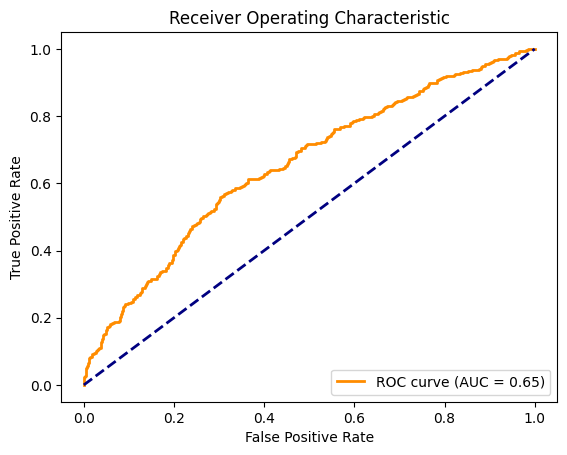

Starting fold n: 2
epoch 1/7 loss: 0.5353, accuracy: 65.73
epoch 2/7 loss: 0.5334, accuracy: 65.85
epoch 3/7 loss: 0.5331, accuracy: 65.97
epoch 4/7 loss: 0.5321, accuracy: 65.95
epoch 5/7 loss: 0.5320, accuracy: 65.93
epoch 6/7 loss: 0.5310, accuracy: 65.91
epoch 7/7 loss: 0.5308, accuracy: 65.89
correct values: 8/16, accuracy for batch: 50.00%, ROC-AUC: 0.72


c:\Users\nicco\OneDrive\Desktop\DHDK\2ndYear\courses\MLfH\ex5\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


correct values: 6/16, accuracy for batch: 37.50%, ROC-AUC: nan
validation loss: 0.6128, validation accuracy: 68.64%


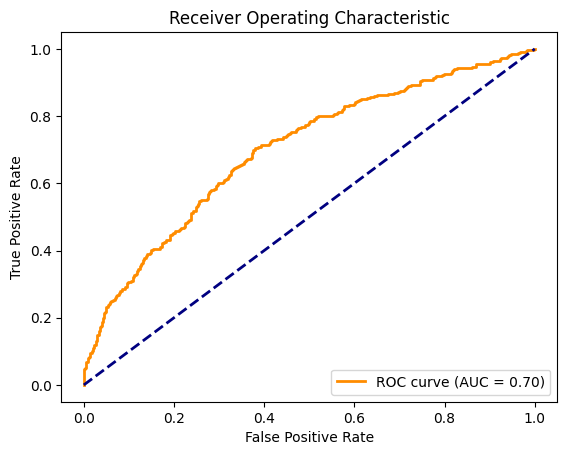

Starting fold n: 3
epoch 1/7 loss: 0.5271, accuracy: 66.29
epoch 2/7 loss: 0.5268, accuracy: 66.45
epoch 3/7 loss: 0.5277, accuracy: 66.50
epoch 4/7 loss: 0.5271, accuracy: 66.56
epoch 5/7 loss: 0.5271, accuracy: 66.60
epoch 6/7 loss: 0.5264, accuracy: 66.68
epoch 7/7 loss: 0.5258, accuracy: 66.68
correct values: 9/16, accuracy for batch: 56.25%, ROC-AUC: 0.60
correct values: 3/16, accuracy for batch: 18.75%, ROC-AUC: 0.33
validation loss: 0.6378, validation accuracy: 67.98%


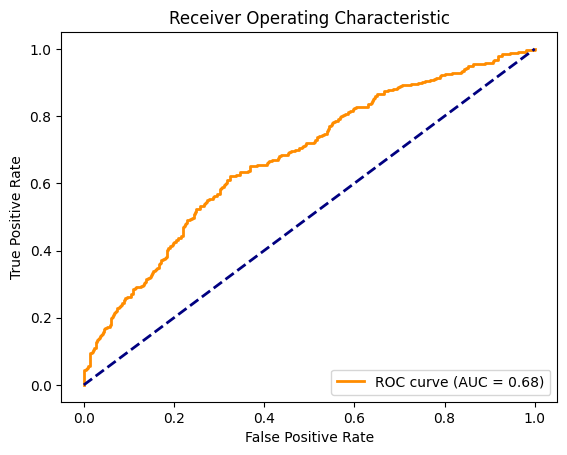

Starting fold n: 4
epoch 1/7 loss: 0.5275, accuracy: 66.32
epoch 2/7 loss: 0.5281, accuracy: 66.23
epoch 3/7 loss: 0.5289, accuracy: 66.17
epoch 4/7 loss: 0.5275, accuracy: 66.18
epoch 5/7 loss: 0.5293, accuracy: 66.16
epoch 6/7 loss: 0.5284, accuracy: 66.28
epoch 7/7 loss: 0.5270, accuracy: 66.33
correct values: 12/16, accuracy for batch: 75.00%, ROC-AUC: 0.89
correct values: 3/16, accuracy for batch: 18.75%, ROC-AUC: 0.33
validation loss: 0.6075, validation accuracy: 69.87%


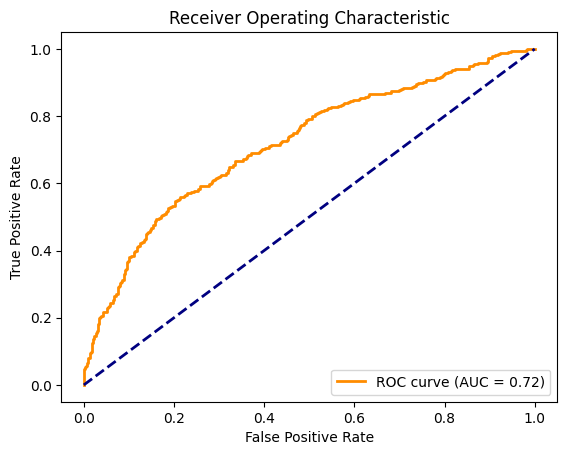

In [183]:
#we use K-fold cross-validation due to limited dataset

kfold = StratifiedKFold(n_splits=4)
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_hmc_data, train_hmc_labels)):
    print(f"Starting fold n: {fold+1}")

    #training!!
    tdata = [train_hmc_data[i] for i in train_idx]
    tlabels = [train_hmc_labels[i] for i in train_idx]

    train_data_df = pd.DataFrame(tdata, columns=["img", "text"])
    train_data_df["label"] = tlabels

    train_ds = dataset_hmc(df=train_data_df, tokenizer=tokenizer, img_path="hateful_memes/")
    train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=d_collator)

    train_model(train_dl, weights)

    #Validation!!
    vdata = [train_hmc_data[i] for i in val_idx]
    vlabels = [train_hmc_labels[i] for i in val_idx]
    
    val_data_df = pd.DataFrame(vdata, columns=["img", "text"])
    val_data_df["label"] = vlabels

    val_ds = dataset_hmc(df=val_data_df, tokenizer=tokenizer, img_path="hateful_memes/")
    val_dl = DataLoader(val_ds, batch_size=16, shuffle=True, collate_fn=d_collator)

    eval_model(val_dl)


correct values: 11/16, accuracy for batch: 68.75%, ROC-AUC: 0.53
correct values: 13/16, accuracy for batch: 81.25%, ROC-AUC: 0.59
correct values: 13/16, accuracy for batch: 81.25%, ROC-AUC: 0.96
correct values: 7/16, accuracy for batch: 43.75%, ROC-AUC: 0.71
0.6812789098637331 <class 'numpy.float64'>
validation loss: 0.7638, validation accuracy: 65.62%


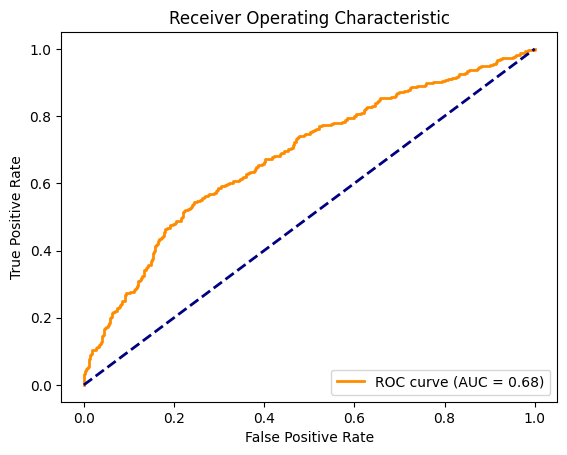

In [159]:
eval_model(test_dataloader_hmc)

In [ ]:
"""hateful_instance = data.query("label == 1.0")
non_hateful_instance = data.query("label == 0.0")
print(len(hateful_instance), len(non_hateful_instance))
hi_fraction = hateful_instance[:1000]
nhi_fraction = non_hateful_instance[:100]

unbalanced_df = pd.concat([hi_fraction, nhi_fraction], ignore_index=True)
unbalanced_df = unbalanced_df.sample(frac=1).reset_index(drop=True)

print(len(unbalanced_df), unbalanced_df.head())"""

In [106]:
"""hateful_instance_ds = dataset_hmc(df=unbalanced_df, tokenizer=tokenizer, img_path="hateful_memes/")
hateful_instance_dl = DataLoader(hateful_instance_ds, batch_size=16, shuffle=True, collate_fn=d_collator)"""

In [ ]:
#eval_model(hateful_instance_dl)

In [ ]:
def choose(instance):
    df_inst = pd.DataFrame(instance)
    ds = dataset_hmc(df=df_inst, tokenizer=tokenizer, img_path="hateful_memes/")
    dl = DataLoader(ds, batch_size=1, shuffle=True, collate_fn=d_collator)
    hmc_model.text_model.eval()
    hmc_model.img_model.eval()
    hmc_model.eval()
    for inst in dl:
        text_data = {
            "input_ids": inst["input_ids"],
            "attention_mask": inst["attention_mask"]
            }
        img = inst["img_tensor"]
        img = img.squeeze(1)
        #label = inst["labels"]
        img_path = os.path.join("hateful_memes/", df_inst["img"])
        
        outputs = hmc_model(text_data,img)
        sm = nn.Softmax(1)
        probs = sm(outputs.data, 1)
        pred = t.argmax(outputs.data, 1)
        if pred == 1 and t.argmax(probs, 1) > 0.70:
            img = Image.open(img_path).convert('RGB')

            # Trasforma l'immagine in un tensore
            im1 = img.filter(ImageFilter.BoxBlur(10))
            im1.show()
            print(f"This image was censored due to containing harmful content. Confidence:{t.argmax(probs,1)}")
        else:
            img = Image.open(img_path).convert('RGB')
            img.show()
            print("This image doesn't seem to contain harmful content")